<a href="https://colab.research.google.com/github/Berenice2018/DeepLearning/blob/master/PySyft_Keystone_Secure_DL_CIFAR10_with_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(notebook copy from Kaggle)

**Issues with PySyft: (state of 2019, August 20th)** 

1.   Unfortunately, PySyft does not support CUDA. https://github.com/OpenMined/PySyft/issues/1893
That is why I decided for a simple and small dataset. 
2.   https://github.com/OpenMined/PySyft/issues/2425
3.https://github.com/OpenMined/PySyft/issues/2426 
4. "AttributeError: 'Linear' object has no attribute 'fix_prec'"
https://github.com/OpenMined/PySyft/pull/2364
5. Running PySyft code often ends up with an empty AssertionError. It is related to the installation process, because `pip install` could not install succesfully. The current PySyft version does not fit with the current PyTorch, TorchVision versions. 
6. PySyft currenlty only supports exactly 2 workers, neither more no less. 
7. We get error messages, when we train with non-linear models, for example while using Convolutional and BatchNorm layers






Data is shared in an encrypted way across multiple end devices via workers
```(data.fix_precision().share(ada, bob, crypto_provider= crypto_provdr)```

The end device downloads the current model, i.e. the model is shared with the end devices: 
``` model.fix_precision().share(ada,bob, crypto_provider=crypto_provdr)```


The end device improves the model by learning from data on that end device, 
and then summarizes the changes as a small focused update. 

It is just this update to the model that is sent to the cloud (secure worker), using encryption, where it is averaged with other updates (coming from end devices) to improve the shared model. 

All the training data remains on the end devices. The model, the inputs, the model outputs, the weights, etc. will be encrypted as well. 

In [0]:
!pip install syft

In [2]:

import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import syft as sy

import os


W0827 12:56:11.471678 140100619605888 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0827 12:56:11.488156 140100619605888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
# Visualize plot
def plot_loss_acc(n_epochs, train_losses, valid_losses, valid_accuracies):
    fig, (ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    ax1.plot(valid_losses, label='Validation loss')
    ax1.plot(train_losses, label='Training loss')
    ax1.legend(frameon=False)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    #x_ticks = [x for x in range(0,n_epochs,2)]
    #plt.xticks(x_ticks)
    
    ax2.plot(valid_accuracies, label = 'Validation accuracy')
    ax2.legend(frameon=False)
    ax2.set_xlabel('Epochs')
    
    plt.tight_layout()

In [0]:
# create workers, 
hook = sy.TorchHook(torch)

ada = sy.VirtualWorker(hook, 'ada')
bob = sy.VirtualWorker(hook, 'bob')
#cyd = sy.VirtualWorker(hook, 'cyd')

client = sy.VirtualWorker(hook, 'client')
crypto_provdr = sy.VirtualWorker(hook, 'crypto_provdr') #gives crypto primitives we may need

In [5]:
# define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5 ), (0.5,0.5,0.5 ))
])

# load the datasets
fulltrainset = datasets.CIFAR10(root='./CIFAR10_data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data', download=True, train=False, transform=transform)

train_size = int(len(fulltrainset)* 0.8)
valid_size = len(fulltrainset) - train_size

# split the dataset
trainset, validationset = torch.utils.data.random_split(fulltrainset, [train_size, valid_size])
trainset = trainset.dataset
validationset = validationset.dataset


0it [00:00, ?it/s]

170500096it [00:04, 40791182.82it/s]                               
0it [00:00, ?it/s]

170500096it [00:04, 41399959.28it/s]                               


In [6]:
# we assume that the server has access to some data to first train its model
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# The client has some data and gets predictions on it using the server's model. 
# The client encrypts its data by sharing it additively across the workers ada, bob, cyd.
valid_loader = torch.utils.data.DataLoader(validationset, batch_size=64, shuffle=True)

private_valid_loader = []
for data, target in valid_loader:
    private_valid_loader.append(
        (data.fix_precision().share(ada, bob, crypto_provdr),
        target.fix_precision().share(ada, bob, crypto_provdr)
        ))

    
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=True)

len_trainloader = len(train_loader)
len_validloader = len(valid_loader)
print(len_trainloader)

# Let's check that our trainloader returns a pointer to a batch, and that transformations are applied
#data, labels = next(iter(train_loader))
#data

782


**Architecture**

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
    # (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
class MyCifarNet(nn.Module):
    def __init__(self):
        super(MyCifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #print('x {}, size {}'.format(x.shape, x.size(0))) # x torch.Size([64, 1, 28, 28]), size 0
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    


**Functions train, test**

In [0]:
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        n = m.in_features
        # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0, 1/np.sqrt(n))
        # m.bias.data should be 0
        m.bias.data.fill_(0)
            

def train(args, model, device, train_loader, optimizer, epoch):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    correct = 0.0
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader): # <-- now it is a distributed dataset
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #print(' \tTrain. Loss: {:.6f}'.format(current_loss))    

        # get the loss per batch and accumulate
        train_loss += loss.item()
        
        
    # calculate the average loss per epoch
    train_loss = train_loss/len(train_loader)
    #print('Epoch: {} \tTrain. Loss: {:.6f}'.format(epoch, train_loss))    
    return train_loss
         

In [0]:
def validate(args, model, device, test_loader):
    model.eval()
    test_loss = 0.
    correct = 0.
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct/len(test_loader.dataset)
    #print('Epoch: {} \tValid. Loss: {:.6f}'.format(epoch, test_loss))    
    return test_loss, accuracy
        

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 64
        self.epochs = 5
        self.lr = 0.001
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


**Start the training**

Epoch: 1 	Train. Loss: 2.079996 	Valid. Loss: 1.957968 	 Accur.: 31.740000
Validation loss decreased by -inf
Epoch: 2 	Train. Loss: 1.902019 	Valid. Loss: 1.855560 	 Accur.: 35.660000
Validation loss decreased by -0.102408
Epoch: 3 	Train. Loss: 1.823125 	Valid. Loss: 1.796728 	 Accur.: 38.130000
Validation loss decreased by -0.058832
Epoch: 4 	Train. Loss: 1.773130 	Valid. Loss: 1.755399 	 Accur.: 39.290000
Validation loss decreased by -0.041329
Epoch: 5 	Train. Loss: 1.749216 	Valid. Loss: 1.751922 	 Accur.: 39.330000
Validation loss decreased by -0.003476


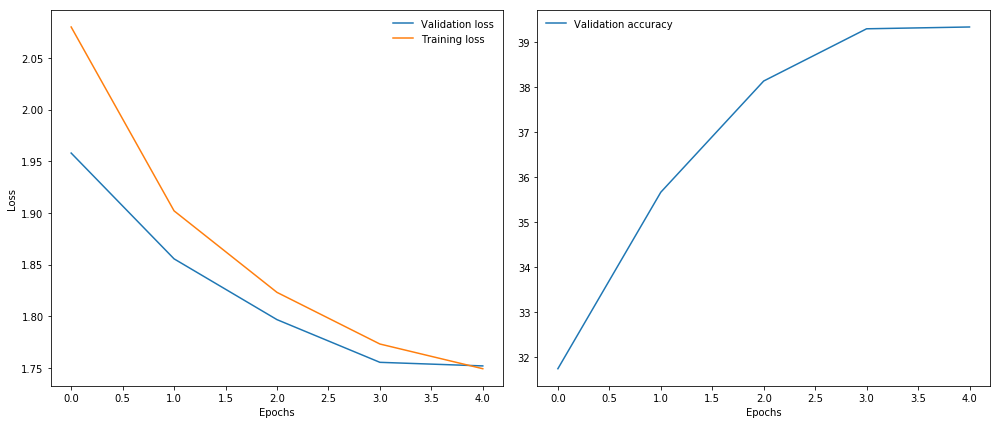

In [11]:
model = Model() # MyCifarNet()
model.apply(weights_init_normal)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 14], 0.1)

valid_losses = []
train_losses = []
valid_accuracies = []
valid_loss_min = np.Inf
    
for epoch in range(1, args.epochs + 1):
    
    # initialize variables to monitor training and validation loss
    training_loss = 0.0
    training_accuracy = 0.0

    if scheduler is not None:
        scheduler.step()
        
    training_loss =  train(args, model, device, train_loader, optimizer, epoch)
    validation_loss, validation_accuracy = validate(args, model, device, test_loader)

    #if scheduler is not None:
      #scheduler.step(validation_loss) # in case of ReduceOnPlateau 

    ###### print training/validation statistics 
    train_losses.append(training_loss)
    valid_losses.append(validation_loss)
    valid_accuracies.append(validation_accuracy)

    #hour, minute, second = get_time()
    print('Epoch: {} \tTrain. Loss: {:.6f} \tValid. Loss: {:.6f} \t Accur.: {:.6f}'.format(
              epoch,
              training_loss,
              validation_loss,
              validation_accuracy ))

    ###### TODO: save the model if validation loss has decreased
    if validation_loss <= valid_loss_min:
        print('Validation loss decreased by {:.6f}'.format(validation_loss - valid_loss_min))
        #torch.save(model.state_dict(), save_path)
        valid_loss_min = validation_loss
    
##### visualize
plot_loss_acc(args.epochs, train_losses, valid_losses, valid_accuracies)

In [12]:
# As the server, send the model to the workers holding the data. The weights are not disclosed
for param in model.parameters():
    param.requires_grad = True
    
model.fix_precision().share(ada, bob, crypto_provider=crypto_provdr)

Model(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [0]:
# perform the encrypted evaluation. The model weights, the data inputs, the prediction and 
# the target used for scoring are encrypted!

def validate_encrypted(args, model, valid_loader):
    model.eval()
    n_correct_private = 0
    n_total = 0
    
    with torch.no_grad(): 
        for data, target in valid_loader:
            output = model(data)
            prediction = output.argmax(1, keepdim=True)
            n_correct_private += prediction.eq(target.view_as(prediction)).sum()
            n_total += args.test_batch_size
            
            #decrypt from the server side the final score of the batch items, 
            # to verify if the predictions were on average good
            n_correct = n_correct_private.copy().get().float_precision().long().item()
            print('Valid. set: Accuracy: {}/{} ({:.0f}%)'.format(
                n_correct, n_total,
                100. * n_correct / n_total))
            

In [19]:
validate_encrypted(args, model, private_valid_loader)

AssertionError: ignored

In [0]:

print(f'objects of ada= {len(ada._objects)}, bob= {len(bob._objects)}, cyd= {len(cyd._objects)}')

#ada.clear_objects()
#bob.clear_objects()
#cyd.clear_objects()